# Trabajo Práctico 3 - Visión por Computadora I

## Detección de Objetos

### Alumno: Domenje Carlos



### ✒️ Enunciado
Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en Material_TPs/TP3/images a partir del template Material_TPs/TP3/template

1. (4 puntos) Obtener una detección del logo en cada imagen sin falsos positivos.

2. (4 puntos) Plantear y validar un algoritmo para múltiples detecciones en la imagen coca_multi.png con el mismo témplate del item 2.

3. (2 puntos) Generalizar el algoritmo del item 2 para todas las imágenes.

Visualizar los resultados con bounding boxes en cada imagen mostrando el nivel de confianza de la detección.

### 💾 Imports de librerias necesarias 


In [1]:

import warnings
warnings.filterwarnings("ignore")
# OpenCV-Python utiliza NumPy para el manejo de imágenes
import numpy as np
# cv2 es el módulo python para acceder a OpenCV 
import cv2 as cv
# Usamos las poderosas herramientas de graficación de matplotlib para mostrar imágenes, perfiles, histogramas, etc
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors
import os

### 📟 Imagen Template

Se realiza la carga del template, se evalua sus dimensiones y se realiza una transformacion Canny para utilizarlo como nuevo template para realizar el analisis. La decision de utilizar Canny es la independecia de cualquier color o fondo que se pueda presentar y que solo se dependa de los bordes de la imagen. Además se deberá tener en cuenta las dimensiones del template con las diferentes imagenes del dataset. 

Tamaño imagen: (175, 400) pix


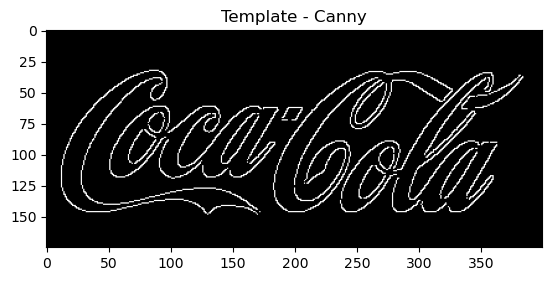

In [2]:
# Cargar imagen del template a utilizar.
imgTemplate = cv.imread('./template/pattern.png',cv.IMREAD_GRAYSCALE )
# Vemos el tamaño del template.
print(f'Tamaño imagen: {imgTemplate.shape} pix')
# Aplicamos Canny a la imagen
newTemplate = cv.Canny(imgTemplate, 350, 350, apertureSize = 3)
plt.figure()
plt.imshow(newTemplate, cmap='gray')
plt.title('Template - Canny')
plt.show()

#### 🌌 Cambio de tamaño de imagen de template
Utilizamos las funciones vistas en la teoria y practica de la catedra para modificar la resolucion de las imagenes.

Tamaño imagen: (598, 799, 3) pix


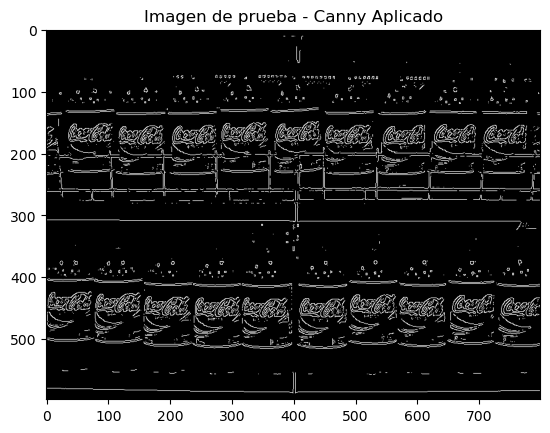

Dimensiones generadas:


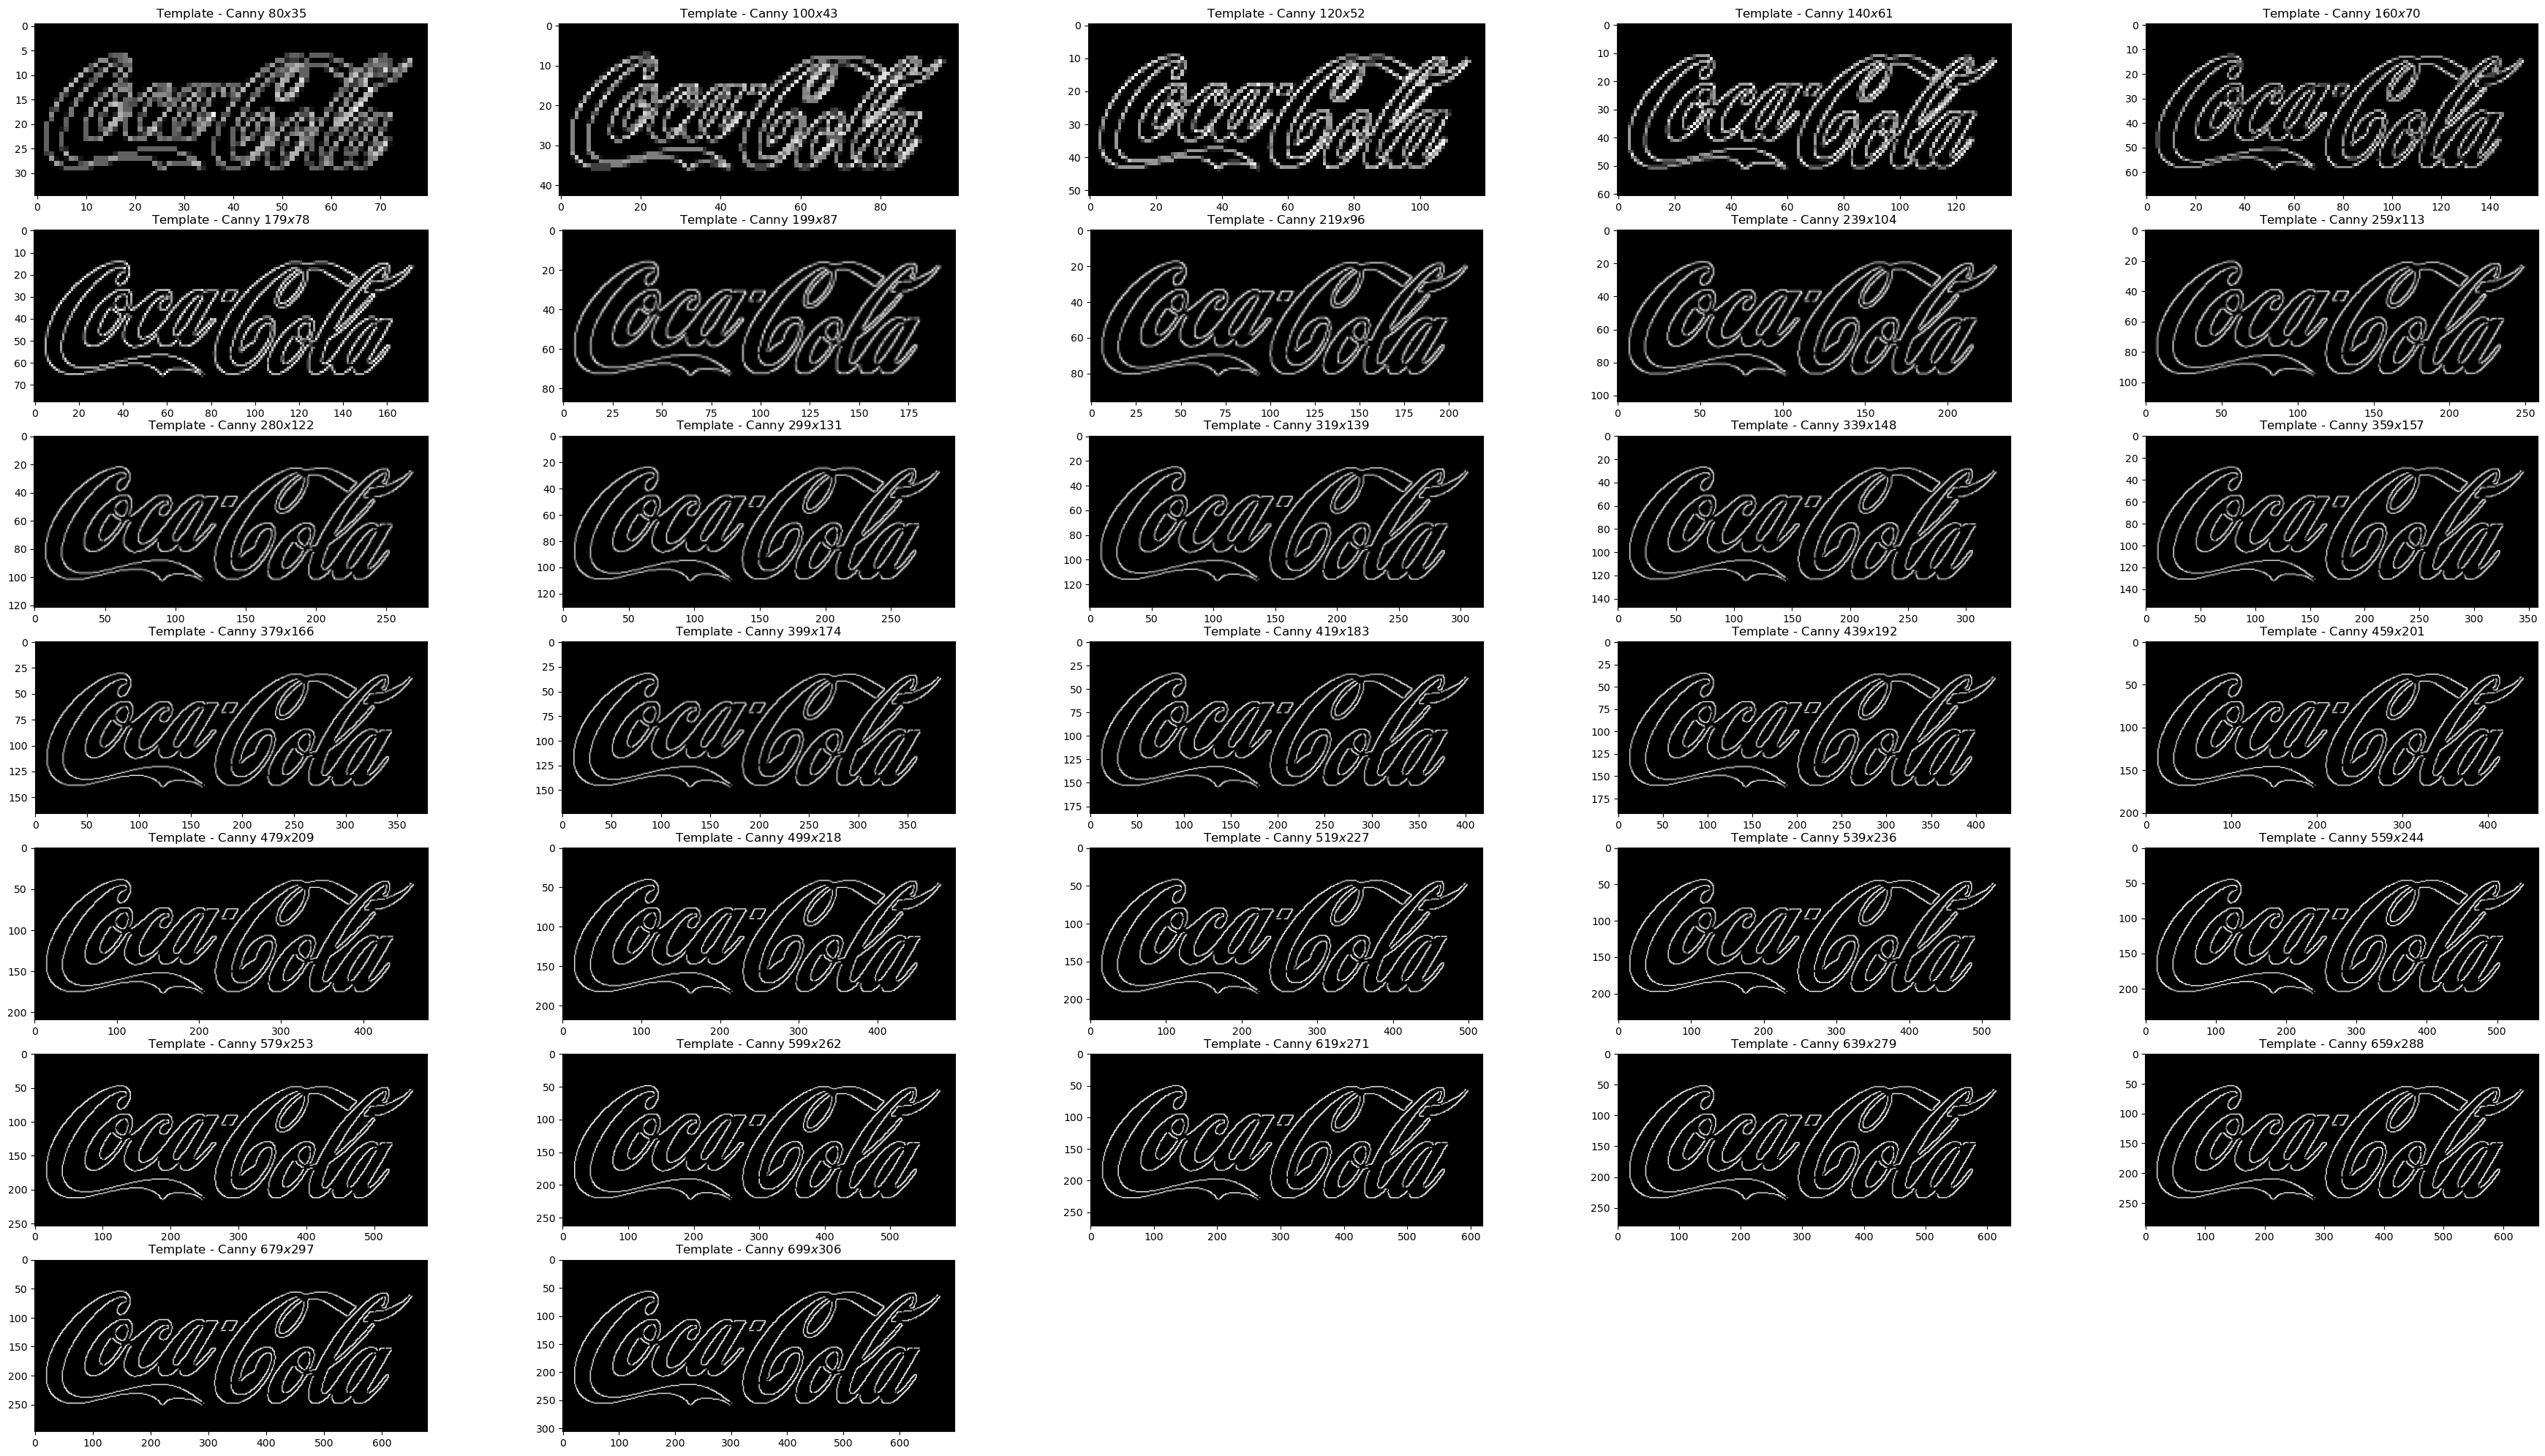

In [3]:
# Carga de 1 imagen para realizar el test
imgPrueba = cv.imread('./images/coca_multi.png')
imgPrueba = cv.cvtColor(imgPrueba,cv.COLOR_BGR2RGB)
imgGray = cv.cvtColor(imgPrueba,cv.COLOR_RGB2GRAY)
# Vemos el tamaño de la imagen.
print(f'Tamaño imagen: {imgPrueba.shape} pix')
# Aplicamos Canny a la imagen
newBorderImg = cv.Canny(imgPrueba, 500, 500, apertureSize = 3)

plt.figure()
plt.imshow(newBorderImg, cmap='gray')
plt.title('Imagen de prueba - Canny Aplicado')
plt.show()


# Tenemos las dimensiones de la imagen y del template
w_img, h_img = newBorderImg.shape[::-1]
w_tmp, h_tmp = newTemplate.shape[::-1]

# Relacion entre el ancho y alto de la imagen vs el template
f_width = w_img / w_tmp
f_height = h_img / h_tmp

# Tomamos el minimo de escala que vimos por inspeccion de dimensiones del template,
# El maximo esta calculado al 90% de la relacion entre el ancho de la imagen y el template.
scales = np.arange(0.20, f_width * 0.9, 0.05)
resized_templates = list()

# Generamos nuestra "piramide" de tamaños arbitrarios
print(f'Dimensiones generadas:')
for scale in scales:
    width = int(newTemplate.shape[1] * scale)
    height = int(newTemplate.shape[0] * scale)
    dim = (width, height)
    resized_templates.append(cv.resize(newTemplate, dim, interpolation = cv.INTER_AREA))
    
Tot = scales.shape[0]
Cols = int(Tot**0.5)
Rows = Tot // Cols 
if Tot % Cols != 0:
    Rows += 1
Position = range(1,Tot + 1)
fig = plt.figure(1,figsize=(45,25))
for k in range(Tot):
  ax = fig.add_subplot(Rows,Cols,Position[k])
  ax.set_title(f'Template - Canny ${resized_templates[k].shape[1]} x ${resized_templates[k].shape[0]}')
  ax.imshow(resized_templates[k], cmap='gray')  

plt.show()

#### 💻 Prueba de detección de logo en una imagen.

Para poder analizar y plantear un codigo generico para la deteccion de un objeto en un set de imagenes, se realiza un testeo de la funcion de match para poder sacar una conclusion en el planteo de una solucion general.

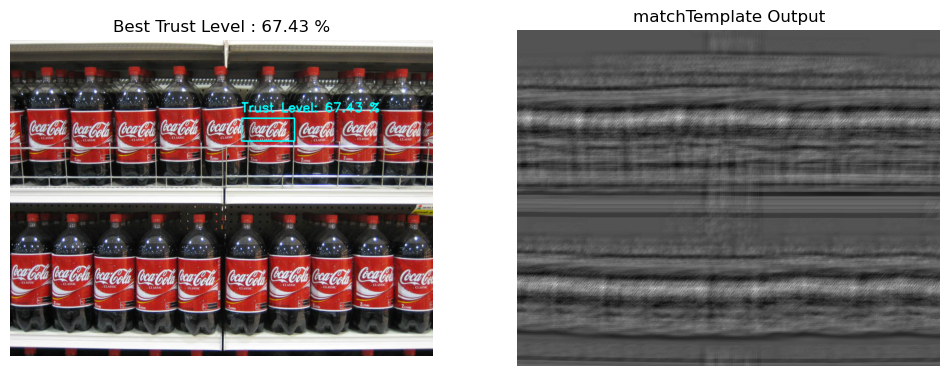

In [4]:

best_trust_level = 0

for template in resized_templates:
    # Dimensiones del template.
    width_template, height_template = template.shape[::-1]
    width_img, height_img = newBorderImg.shape[::-1]
    
    #print(f'Tamaño Template: {width_template}px x {height_template}px')
    #print(f'Tamaño Imagen: {width_img}px x {height_img}px')
    
    # Realizamos la operacion de match solo si el template es menor a la imagen
    if (width_template < width_img):
     
        matchTemp = cv.matchTemplate(newBorderImg, template, cv.TM_CCOEFF)
        
        min_val, max_val, min_loc, max_loc = cv.minMaxLoc(matchTemp)
        w, h = matchTemp.shape[::-1]
        # Para obtener un valor del nivel de confiaza se opto por tomar la relacion entre el valor maximo
        # y la diferencia entre el maximo y minimo dado en cada match
        trust_level = max_val / (max_val - min_val)
        # Nos quedamos con el mayor obtenido.
        if (trust_level > best_trust_level):
            best_trust_level = trust_level
            top_left = max_loc
            img_match = matchTemp.copy()
            imgTest = imgPrueba.copy()
            bottom_right = (top_left[0] + width_template, top_left[1] + height_template)
        
        
cv.rectangle(imgTest,top_left, bottom_right, [0,255,255], 2)
cv.putText(imgTest, f"Trust Level: {(best_trust_level * 100):.2f} %", (top_left[0],top_left[1]-12), cv.FONT_HERSHEY_SIMPLEX, 0.8, [0,255,255], 2)
plt.figure(figsize=(12,12))

plt.subplot(1,2,1)
plt.axis('off')
plt.title(f"Best Trust Level : {(best_trust_level* 100):.2f} %")
plt.imshow(imgTest)

plt.subplot(1,2,2)
plt.axis('off')
plt.title("matchTemplate Output")
plt.imshow(img_match,cmap='gray')
plt.show()    
      

#### 🔎 Analisis para multiples matchs.

Se plantea la solución a la deteccion de multiples objetos iguales que aparezcan en la imagen. 

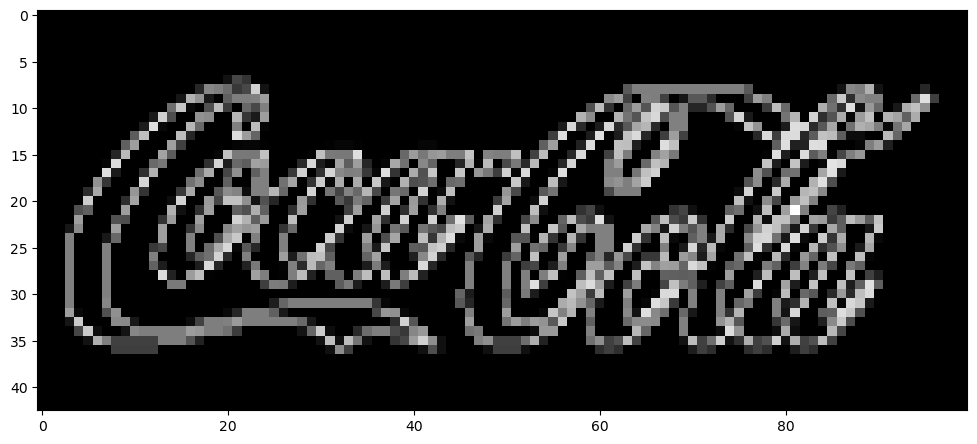

0.24402829


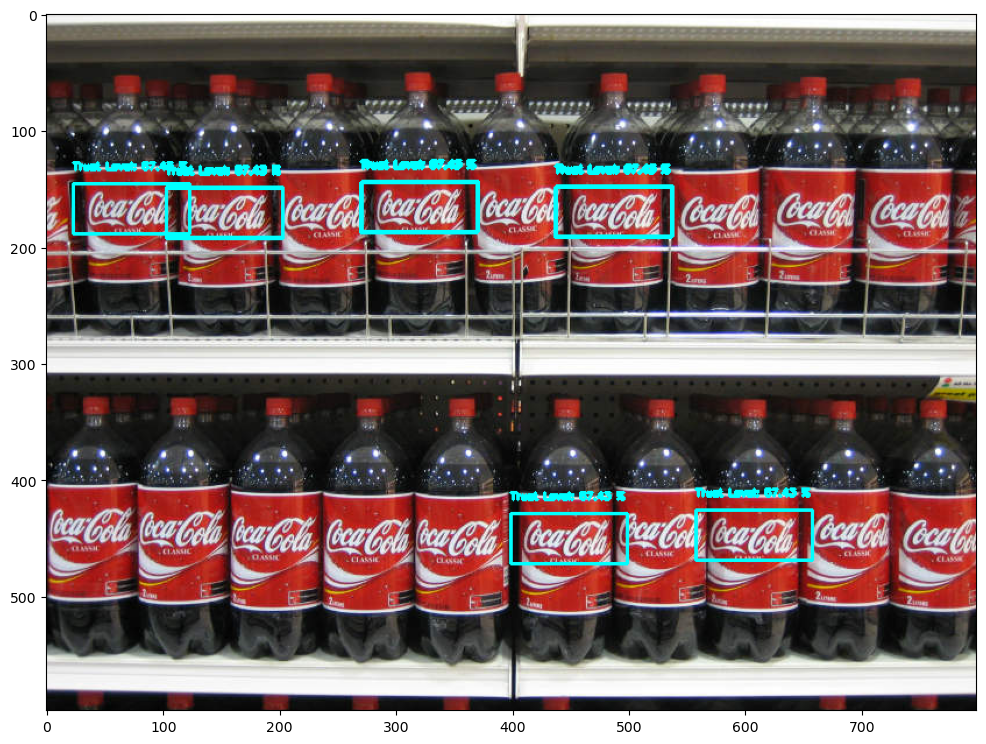

In [5]:

best_trust_level = 0

for template in resized_templates:
    # Dimensiones del template.
    width_template, height_template = template.shape[::-1]
    width_img, height_img = newBorderImg.shape[::-1]
    # Realizamos la operacion de match solo si el template es menor a la imagen
    if (width_template < width_img):
        matchTemp = cv.matchTemplate(newBorderImg, template, cv.TM_CCOEFF)
        min_val, max_val, min_loc, max_loc = cv.minMaxLoc(matchTemp)
        w, h = matchTemp.shape[::-1]
        # Para obtener un valor del nivel de confiaza se opto por tomar la relacion entre el valor maximo
        # y la diferencia entre el maximo y minimo dado en cada match
        trust_level = max_val / (max_val - min_val)
        # Nos quedamos con el mayor obtenido.
        if (trust_level > best_trust_level):
            best_trust_level = trust_level
            best_template = template.copy()
           
# Copiamos la imagen de prueba.             
imgMulti = imgPrueba.copy()        
# Al llegar a este punto encontre el mejor template

w, h = best_template.shape[::-1]
plt.figure(figsize=(12,12))
plt.imshow(best_template,cmap='gray')    
plt.show() 
# Vuelvo a aplicar el match entre la imagen y el mejor template encontrado. 
res = cv.matchTemplate(newBorderImg,best_template,cv.TM_CCOEFF_NORMED)
print(res.max())
# Tenemos que ver el umbral en funcion del valor maximo que resuelve el matchTemplate.

# Fijamos un umbral de "coincidencia"
threshold = 0.85 
# La localizacion de los puntos de match dependen de un porcentaje del maximo valor encontrado en la imagen. 
loc = np.where( res >= threshold * res.max())

for pt in zip(*loc[::-1]):
    cv.putText(imgMulti, f"Trust Level: {(best_trust_level * 100):.2f} %", (pt[0],pt[1]-12), cv.FONT_HERSHEY_SIMPLEX, 0.3, [0,255,255], 2)
    cv.rectangle(imgMulti, pt, (pt[0] + w, pt[1] + h), (0,255,255), 2)

plt.figure(figsize=(12,12))
plt.imshow(imgMulti)    
plt.show()      

      

### 🔧 Construccion de una clase para generalizar la deteccion de objetos en diferentes imagenes. 

Se construirá una clase donde pueda ser instanciada y asi lograr cargar el dataset de imagenes y el template para lograr las detecciones en cada una de ellas. Tendra dos metodos para lograr por un lado detectar un template y otro para multiples detecciones. 

In [14]:

################################################################################################### 
##################### CLASE MATCH-TEMPLATE
################################################################################################### 
class match_template():
    
    
    def __init__(self) -> None:
        self.imgTemplate = None
        self.path_images = None
        self.path_image = None
        self.resized_templates = list()
        
        pass
    
    
    ###################################################################################################
    ################################################################################################### 
    ##################### CARGA DE IMAGEN DEL TEMPLATE
    ################################################################################################### 
    ###################################################################################################  
    def load_template(self, template_path):
        # Cargar imagen del template a utilizar.
        self.imgTemplate = cv.imread(template_path,cv.IMREAD_GRAYSCALE )
        # Vemos el tamaño del template.
        print(f'Tamaño imagen: {imgTemplate.shape} pix')
        # Aplicamos Canny a la imagen
        # self.newTemplate = cv.Canny(imgTemplate, 350, 350, apertureSize = 3)
        plt.figure()
        plt.imshow(self.imgTemplate, cmap='gray')
        plt.title('Template - Canny')
        plt.show()
        
    ###################################################################################################
    ################################################################################################### 
    ##################### Carga del dataset
    ################################################################################################### 
    ###################################################################################################  
    def load_dataset(self, images_path):
        self.path_image = images_path
        self.path_images = os.listdir(images_path)
        
        
    ###################################################################################################
    ################################################################################################### 
    ##################### FUNCION INTERNA DE ESCALADO DE TEMPLATE
    ################################################################################################### 
    ###################################################################################################      
    def scaling_template(self, template:np.ndarray, image:np.ndarray,p_canny=800, show_generated_templates=False):
        
        # Aplicamos Canny al template cargado
        self.newTemplate = cv.Canny(template, 350, 350, apertureSize = 3)
        # Tenemos las dimensiones de la imagen y del template
        w_img, h_img = image.shape[::-1]
        w_tmp, h_tmp = template.shape[::-1]

        # Relacion entre el ancho y alto de la imagen vs el template
        f_width = w_img / w_tmp
        f_height = h_img / h_tmp

        # Tomamos el minimo de escala que vimos por inspeccion de dimensiones del template,
        # El maximo esta calculado al 90% de la relacion entre el ancho de la imagen y el template.
        scales = np.arange(0.20, f_width * 0.9, 0.05)
        #self.resized_templates = list()

        # Generamos nuestra "piramide" de tamaños arbitrarios
        print(f'Dimensiones generadas:')
        for scale in scales:
            width = int(self.newTemplate.shape[1] * scale)
            height = int(self.newTemplate.shape[0] * scale)
            dim = (width, height)
            self.resized_templates.append(cv.resize(self.newTemplate, dim, interpolation = cv.INTER_AREA))
        if (show_generated_templates):    
            Tot = scales.shape[0]
            Cols = int(Tot**0.5)
            Rows = Tot // Cols 
            if Tot % Cols != 0:
                Rows += 1
            Position = range(1,Tot + 1)
            fig = plt.figure(1,figsize=(45,25))
            for k in range(Tot):
                ax = fig.add_subplot(Rows,Cols,Position[k])
                ax.set_title(f'Template - Canny ${self.resized_templates[k].shape[1]} x ${self.resized_templates[k].shape[0]}')
                ax.imshow(self.resized_templates[k], cmap='gray')  

            plt.show()
            
        return self.resized_templates
    
        
    ###################################################################################################
    ################################################################################################### 
    ##################### DETECCION SIMPLE
    ################################################################################################### 
    ###################################################################################################          
    def single_detection(self):
        best_trust_level = 0
        #Recorremos todas las imagenes del dataset.
        for image in self.path_images:
            print(self.path_image + image)
            load_image = cv.imread(self.path_image + image)
            load_image = cv.cvtColor(load_image,cv.COLOR_BGR2RGB)
            gray_image = cv.cvtColor(load_image,cv.COLOR_RGB2GRAY)
            image_canny = cv.Canny(gray_image, 600, 600, apertureSize = 3)
            
            resized_templates = self.scaling_template(self.imgTemplate,gray_image)
            
            for template in resized_templates:
                # Dimensiones del template.
                width_template, height_template = template.shape[::-1]
                width_img, height_img = image_canny.shape[::-1]
                
                # Realizamos la operacion de match solo si el template es menor a la imagen
                if (width_template < width_img):
                
                    matchTemp = cv.matchTemplate(image_canny, template, cv.TM_CCOEFF)
                    
                    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(matchTemp)
                    w, h = matchTemp.shape[::-1]
                    # Para obtener un valor del nivel de confiaza se opto por tomar la relacion entre el valor maximo
                    # y la diferencia entre el maximo y minimo dado en cada match
                    trust_level = max_val / (max_val - min_val)
                    # Nos quedamos con el mayor obtenido.
                    if (trust_level > best_trust_level):
                        best_trust_level = trust_level
                        top_left = max_loc
                        imgTest = load_image.copy()
                        bottom_right = (top_left[0] + width_template, top_left[1] + height_template)
                 
            cv.rectangle(imgTest,top_left, bottom_right, [0,255,255], 2)
            cv.putText(imgTest, f"Trust Level: {(best_trust_level * 100):.2f} %", (top_left[0],top_left[1]-12), cv.FONT_HERSHEY_SIMPLEX, 0.8, [0,255,255], 2)
            plt.figure()
            plt.axis('off')
            plt.title(f"Best Trust Level : {(best_trust_level* 100):.2f} %")
            plt.imshow(imgTest)
            plt.show()
            best_trust_level = 0
            
    ###################################################################################################
    ################################################################################################### 
    ##################### DETECCION MULTIPLE
    ################################################################################################### 
    ###################################################################################################         
    def multi_detection(self,image_multi_path, threshold=0.85):
        self.path_multi_images = os.listdir(image_multi_path)
        best_trust_level = 0
        #Recorremos todas las imagenes del dataset.
        for image in self.path_multi_images:
            print(self.path_image + image)
            load_image = cv.imread(self.path_image + image)
            load_image = cv.cvtColor(load_image,cv.COLOR_BGR2RGB)
            gray_image = cv.cvtColor(load_image,cv.COLOR_RGB2GRAY)
            image_canny = cv.Canny(gray_image, 600, 600, apertureSize = 3)
            
            resized_templates = self.scaling_template(self.imgTemplate,gray_image)
            
            for template in resized_templates:
                # Dimensiones del template.
                width_template, height_template = template.shape[::-1]
                width_img, height_img = image_canny.shape[::-1]
                
                # Realizamos la operacion de match solo si el template es menor a la imagen
                if (width_template < width_img):
                
                    matchTemp = cv.matchTemplate(image_canny, template, cv.TM_CCOEFF)
                    
                    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(matchTemp)
                    w, h = matchTemp.shape[::-1]
                    # Para obtener un valor del nivel de confiaza se opto por tomar la relacion entre el valor maximo
                    # y la diferencia entre el maximo y minimo dado en cada match
                    trust_level = max_val / (max_val - min_val)
                    # Nos quedamos con el mayor obtenido.
                    if (trust_level > best_trust_level):
                        best_trust_level = trust_level
                        best_template = template.copy()
                        
        # Copiamos la imagen de prueba.             
        imgMulti = load_image.copy()        
        # Al llegar a este punto encontre el mejor template

        w, h = best_template.shape[::-1]
        plt.figure(figsize=(12,12))
        plt.imshow(best_template,cmap='gray')    
        plt.show() 
        # Vuelvo a aplicar el match entre la imagen y el mejor template encontrado. 
        res = cv.matchTemplate(image_canny,best_template,cv.TM_CCOEFF_NORMED)
        print(res.max())
        # Tenemos que ver el umbral en funcion del valor maximo que resuelve el matchTemplate.

        # Fijamos un umbral de "coincidencia"
        threshold = threshold
        # La localizacion de los puntos de match dependen de un porcentaje del maximo valor encontrado en la imagen. 
        loc = np.where( res >= threshold * res.max())

        for pt in zip(*loc[::-1]):
            cv.putText(imgMulti, f"Trust Level: {(best_trust_level * 100):.2f} %", (pt[0],pt[1]-12), cv.FONT_HERSHEY_SIMPLEX, 0.3, [0,255,255], 2)
            cv.rectangle(imgMulti, pt, (pt[0] + w, pt[1] + h), (0,255,255), 2)

        plt.figure(figsize=(12,12))
        plt.imshow(imgMulti)    
        plt.show()      

        


Tamaño imagen: (175, 400) pix


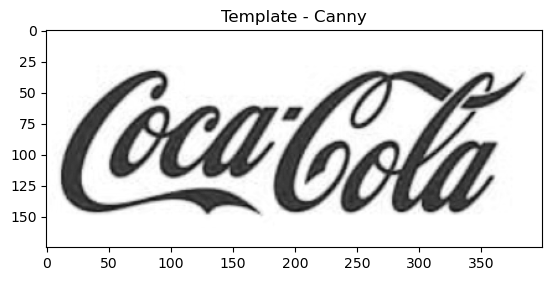

./images/COCA-COLA-LOGO.jpg
Dimensiones generadas:


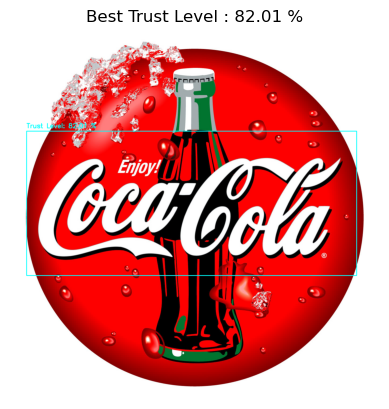

./images/coca_multi.png
Dimensiones generadas:


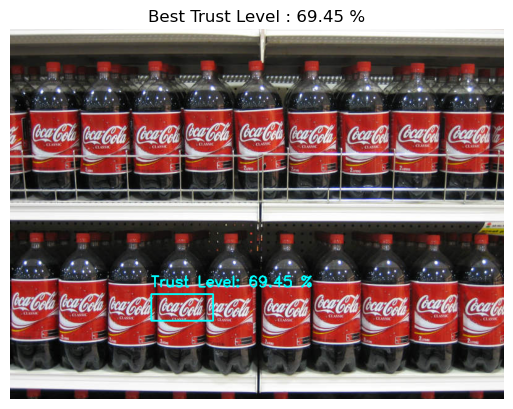

./images/coca_logo_1.png
Dimensiones generadas:


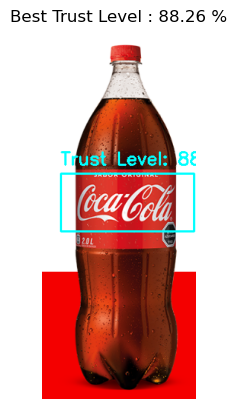

./images/coca_retro_1.png
Dimensiones generadas:


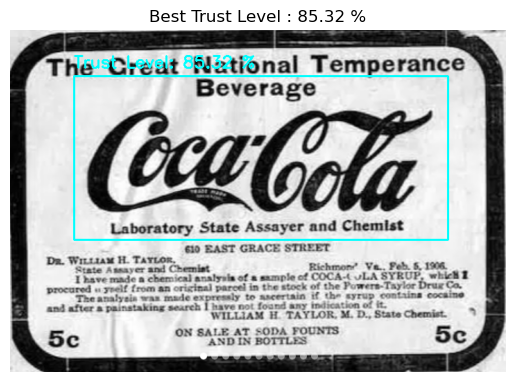

./images/logo_1.png
Dimensiones generadas:


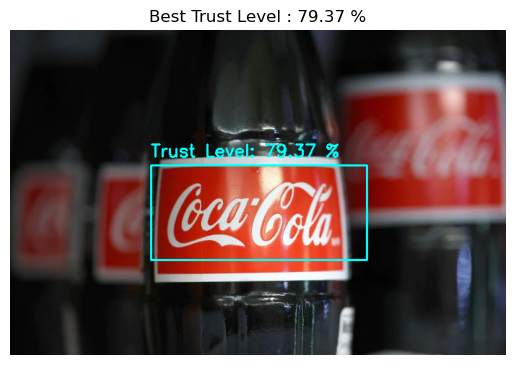

./images/coca_logo_2.png
Dimensiones generadas:


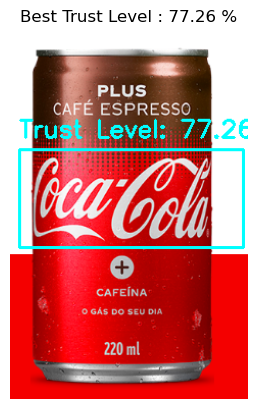

./images/coca_retro_2.png
Dimensiones generadas:


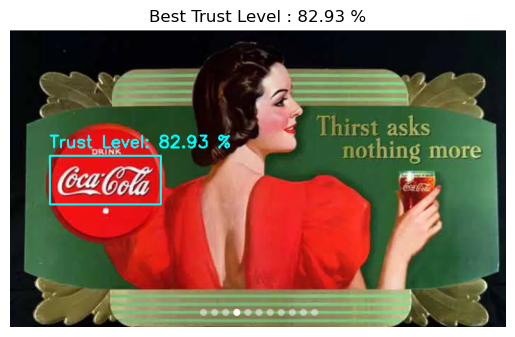

./images/coca_multi.png
Dimensiones generadas:


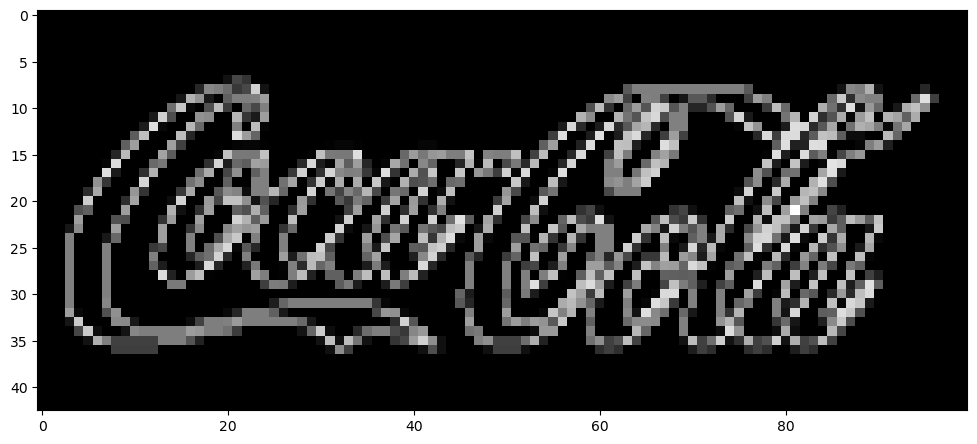

0.22101657


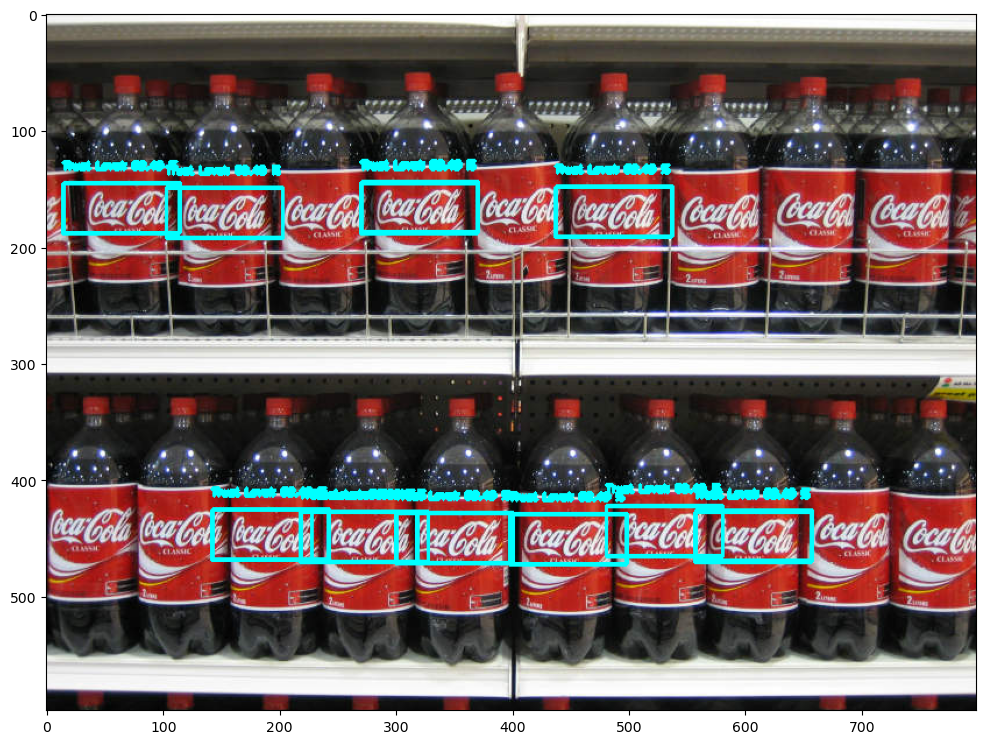

In [16]:
# Generamos una instancia de la clase match_template
detection = match_template()

# Cargamos la imagen del template
detection.load_template('./template/pattern.png')

# Cargamos el dataset para deteccion simple
detection.load_dataset('./images/')

# Llamamos a la funcion de deteccion simple
detection.single_detection()

# Llamamos a la funcion de deteccion multiple
# Para esta funcion necesitamos enviarle el path donde encontrar 
# las imagenes para deteccion multiple solamente.
detection.multi_detection('./multi/', threshold=0.75)


### 📊 Conclusión

Se pudo realizar la implementacion del match template tanto para detecciones simples como para multiples. 
En primer lugar se realizaron a modo de testeo la deteccion de una sola imagen tanto para simple como para multiple. Se tomo la decision de hacerlo de esta manera, ya que entre una y otra los parametros de las diferentes funciones cambian y mejoran o empeoran la deteccion segun estos cambien, entonces para detecciones multiples nos sirven algunos valores pero no en deteccion simple.
Para buscar una metrica de confianza en la deteccion se opto por tomar la relacion entre el valor maximo y la diferencia entre los valores max y min que nos devuelve la funcion minMaxLoc. Por otro lado, se decidio fijar el metodo en la funcion de deteccion a TM_CCOEFF ya que luego de realizar varias pruebas se concluyo que este metodo es el mejor para esta aplicacion.
Por ultimo, se decidio unificar los metodos de deteccion en una clase donde tenemos las dos funciones para implementar, ademas de poder cargar un dataset de imagen donde aplicar las funciones. 